# 快速入门：MNIST手写数字识别

本节通过MindSpore的API来快速实现一个简单的深度学习模型，并使用高阶封装`Model`进行模型训练、评估和推理。

![model](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r1.10/tutorials/source_zh_cn/advanced/model/images/model.png)

## 环境准备

1. 安装MindSpore 1.10

    请参考[此链接](https://gitee.com/mindspore/docs/tree/r1.10/install)，选择对应硬件的安装指南。

    如：希望在windows CPU上安装MindSpore，建议点击mindspore_cpu_win_install_pip.md查看安装指南

2. 安装download

    `pip install download`
    
3. 安装matplotlib

    `pip install matplotlib`

In [1]:
import mindspore
from mindspore import nn
from mindspore.dataset import MnistDataset, vision, transforms
from mindspore.train import Model, CheckpointConfig, ModelCheckpoint, LossMonitor

## 下载并处理数据集

### 数据集加载
`mindspore.dataset`提供的接口仅支持解压后的数据文件，因此我们使用`download`库下载数据集并解压。

In [10]:
# Download data from open datasets
from download import download

url = "https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/" \
      "notebook/datasets/MNIST_Data.zip"
path = download(url, "./", kind="zip", replace=True)

train_dataset = MnistDataset('MNIST_Data/train')
test_dataset = MnistDataset('MNIST_Data/test')


file_sizes: 100%|██████████████████████████| 10.8M/10.8M [00:01<00:00, 10.3MB/s]
Extracting zip file...
Successfully downloaded / unzipped to ./


### 数据集处理

通常情况下，直接加载的原始数据并不能直接送入神经网络中进行训练，此时我们需要对其进行数据预处理。MindSpore提供不同种类的数据变换（Transforms），配合数据处理Pipeline来实现数据预处理。所有的Transforms均可通过`map`方法传入，实现对指定数据列的处理。

In [11]:
# 定义数据处理Pipline
def datapipe(dataset, batch_size):
    image_transforms = [
        vision.Rescale(1.0 / 255.0, 0),
        vision.Normalize(mean=(0.1307,), std=(0.3081,)),
        vision.HWC2CHW()
    ]
    label_transform = transforms.TypeCast(mindspore.int32)

    dataset = dataset.map(image_transforms, 'image')
    dataset = dataset.map(label_transform, 'label')
    dataset = dataset.batch(batch_size, drop_remainder=True)
    return dataset

train_dataset = datapipe(train_dataset, 64)
test_dataset = datapipe(test_dataset, 64)

In [12]:
image, label = next(train_dataset.create_tuple_iterator())
print(image.shape)
print(label.shape)

(64, 1, 28, 28)
(64,)


对MNIST训练数据集进行可视化

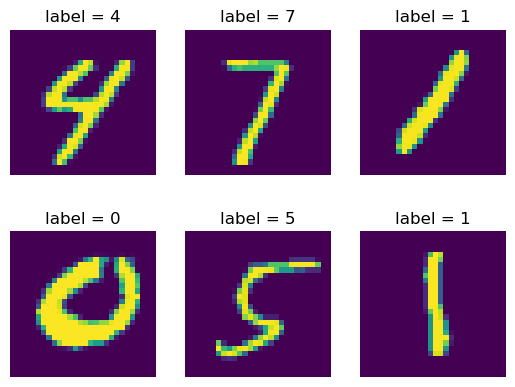

In [13]:
import matplotlib.pyplot as plt
import numpy as np

image, label = next(train_dataset.create_tuple_iterator())
image = image.asnumpy()
label = label.asnumpy()

plt.figure()
for i in range(6):
    plt.subplot(2, 3, i+1)
    image_trans = np.transpose(image[i], (1, 2, 0))
    mean = 0.1307
    std = 0.3081
    image_trans = image_trans * std + mean
    image_trans = np.clip(image_trans, 0, 1)
    plt.title(f"label = {label[i]}")
    plt.imshow(image_trans)
    plt.axis("off")
plt.show()

## 创建模型

神经网络模型是由神经网络层和Tensor操作构成的，MindSpore中通过构建类的方式构建神经网络。

Cell类是构建所有网络的积累，也是网络的基本单元。定义模型类时，可以继承`nn.Cell`类，在`__init__`方法中进行子Cell的实例化和状态管理，在`construct`方法中实现Tensor操作。

In [14]:
# Define model
class Network(nn.Cell):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.dense_relu_sequential = nn.SequentialCell(
            nn.Dense(28*28, 512),
            nn.ReLU(),
            nn.Dense(512, 512),
            nn.ReLU(),
            nn.Dense(512, 10)
        )

    def construct(self, x):
        x = self.flatten(x)
        logits = self.dense_relu_sequential(x)
        return logits

model = Network()

## 定义损失函数和优化器

要训练神经网络模型，需要定义损失函数和优化器函数。

- 损失函数这里使用交叉熵损失函数`CrossEntropyLoss`。
- 优化器这里使用`SGD`。

In [15]:
# Instantiate loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = nn.SGD(model.trainable_params(), 1e-2)

## 训练及保存模型

### Model基本介绍

[Model](https://www.mindspore.cn/docs/en/r1.10/api_python/mindspore/mindspore.Model.html#mindspore.Model)是MindSpore提供的高阶API，可以进行模型训练、评估和推理。其接口的常用参数如下：

- `network`：用于训练或推理的神经网络。
- `loss_fn`：所使用的损失函数。
- `optimizer`：所使用的优化器。
- `metrics`：用于模型评估的评价函数。
- `eval_network`：模型评估所使用的网络，未定义情况下，`Model`会使用`network`和`loss_fn`进行封装。

`Model`提供了以下接口用于模型训练、评估和推理：

- `fit`：边训练边评估模型。
- `train`：用于在训练集上进行模型训练。
- `eval`：用于在验证集上进行模型评估。
- `predict`：用于对输入的一组数据进行推理，输出预测结果。

### 使用Model接口

对于简单场景的神经网络，可以在定义`Model`时指定前向网络`network`、损失函数`loss_fn`、优化器`optimizer`和评价函数`metrics`。

### 定义Callback

在深度学习训练中，为及时掌握网络模型的训练状态、实时观察网络模型各参数的变化情况和实现训练过程中用户自定义的一次额操作，MindSpore提供了回调机制（Callback）来实现上述功能。

Callback回调机制一般用在网络模型训练过程`Model.train`中，MindSpore的`Model`会按照Callback列表`callbacks`顺序执行回调函数。

在本次任务中，开始训练之前，MindSpore需要提前声明网络模型在训练过程中是否需要保存中间过程和结果，因此使用`ModelCheckpoint`接口用于保存网络模型和参数，以便进行后续的Fine-tuning（微调）操作。

In [16]:
steps_per_epoch = train_dataset.get_dataset_size()
config = CheckpointConfig(save_checkpoint_steps=steps_per_epoch)

ckpt_callback = ModelCheckpoint(prefix="mnist", directory="./checkpoint", config=config)
loss_callback = LossMonitor(steps_per_epoch)

通过MindSpore提供的`model.fit`接口可以方便地进行网络的训练，`LossMonitor`可以监控训练过程中`loss`值的变化。

In [17]:
trainer = Model(model, loss_fn=loss_fn, optimizer=optimizer, metrics={'accuracy'})

epochs = 10
trainer.fit(epochs, train_dataset, test_dataset, callbacks=[ckpt_callback, loss_callback])

epoch: 1 step: 937, loss is 0.7588297128677368
Eval result: epoch 1, metrics: {'accuracy': 0.8520633012820513}
epoch: 2 step: 937, loss is 0.24018849432468414
Eval result: epoch 2, metrics: {'accuracy': 0.8982371794871795}
epoch: 3 step: 937, loss is 0.21896855533123016
Eval result: epoch 3, metrics: {'accuracy': 0.9168669871794872}
epoch: 4 step: 937, loss is 0.20035885274410248
Eval result: epoch 4, metrics: {'accuracy': 0.9297876602564102}
epoch: 5 step: 937, loss is 0.2787467837333679
Eval result: epoch 5, metrics: {'accuracy': 0.9372996794871795}
epoch: 6 step: 937, loss is 0.1624264419078827
Eval result: epoch 6, metrics: {'accuracy': 0.9431089743589743}
epoch: 7 step: 937, loss is 0.21562610566616058
Eval result: epoch 7, metrics: {'accuracy': 0.9499198717948718}
epoch: 8 step: 937, loss is 0.18248394131660461
Eval result: epoch 8, metrics: {'accuracy': 0.9529246794871795}
epoch: 9 step: 937, loss is 0.12610052525997162
Eval result: epoch 9, metrics: {'accuracy': 0.9587339743589

训练过程中会打印loss值，loss值会波动，但总体来说loss值会逐步减小，精度逐步提高。每个人运行的loss值有一定随机性，不一定完全相同。

通过模型运行测试数据集得到的结果，验证模型的泛化能力：

1. 使用`model.eval`接口读入测试数据集。
2. 使用保存后的模型参数进行推理。

In [18]:
acc = trainer.eval(test_dataset)
acc

{'accuracy': 0.9621394230769231}

可以在打印信息中看出模型精度数据，示例中精度数据达到95%以上，模型质量良好。随着网络迭代次数增加，模型精度会进一步提高。

## 模型推理

我们使用`model.predict`，加载训练好的模型对图片进行分类预测。

(64, 10)


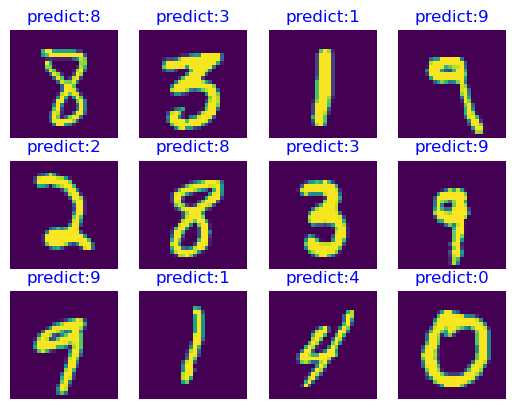

In [26]:
test_data = test_dataset.create_tuple_iterator()
image, label = next(test_data)

# 执行模型预测
output = trainer.predict(image)
print(output.shape)
pred = output.argmax(-1).asnumpy()

# 预测结果可视化

plt.figure()
for i in range(12):
    plt.subplot(3, 4, i+1)
    # 若预测正确，显示为蓝色；若预测错误，显示为红色
    color = 'blue' if pred[i] == label.asnumpy()[i] else 'red'
    image_trans = np.transpose(image.asnumpy()[i], (1, 2, 0))
    mean = 0.1307
    std = 0.3081
    image_trans = image_trans * std + mean
    image_trans = np.clip(image_trans, 0, 1)
    plt.title('predict:{}'.format(pred[i]), color=color)
    plt.imshow(image_trans)
    plt.axis("off")
plt.show()

## 模型保存与加载

训练好的模型权重会被保存为ckpt文件，用于后续的推理部署或是微调。

要加载模型权重，需要先创建相同模型的实例，然后使用load_checkpoint和load_param_into_net方法加载参数。

> `load_param_into_net`返回的是未被加载的参数列表，为空时代表所有参数均加载成功。

In [14]:
model = Network()

In [20]:
model_ckpt = f"checkpoint/mnist-{epochs}_{steps_per_epoch}.ckpt"

In [21]:
model_ckpt

'checkpoint/mnist-10_937.ckpt'

In [23]:
param_dict = mindspore.load_checkpoint(model_ckpt)

In [24]:
mindspore.load_param_into_net(model, param_dict)

[]